In [1]:
import numpy as np
import pandas as pd
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas.core.dtypes.common import is_numeric_dtype
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend, layers, losses, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")
random_state=42
%matplotlib inline

################################

# PART-A

################################

## 1. Data import and Understanding

### A. Read the ‘Signals.csv’ as DataFrame and import required libraries.

In [2]:
# signals=pd.read_csv('/content/drive/MyDrive/GL/Signal.csv')
signals=pd.read_csv("Signals.csv")
signals_original=signals.copy(deep=True)
signals.head()

Parameter 1  Parameter 2  Parameter 3  Parameter 4  Parameter 5  \
0          7.4         0.70         0.00          1.9        0.076   
1          7.8         0.88         0.00          2.6        0.098   
2          7.8         0.76         0.04          2.3        0.092   
3         11.2         0.28         0.56          1.9        0.075   
4          7.4         0.70         0.00          1.9        0.076   

   Parameter 6  Parameter 7  Parameter 8  Parameter 9  Parameter 10  \
0         11.0         34.0       0.9978         3.51          0.56   
1         25.0         67.0       0.9968         3.20          0.68   
2         15.0         54.0       0.9970         3.26          0.65   
3         17.0         60.0       0.9980         3.16          0.58   
4         11.0         34.0       0.9978         3.51          0.56   

   Parameter 11  Signal_Strength  
0           9.4                5  
1           9.8                5  
2           9.8                5  
3           9.8                6  
4           9.4                5

In [3]:
signals.shape

(1599, 12)

Signals dataset contains 1599 entries with 12 features.

### B. Check for missing values and print percentage for each attribute.

In [4]:
# To check the missing data percentage
signals.isnull().mean()*100

Parameter 1        0.0
Parameter 2        0.0
Parameter 3        0.0
Parameter 4        0.0
Parameter 5        0.0
Parameter 6        0.0
Parameter 7        0.0
Parameter 8        0.0
Parameter 9        0.0
Parameter 10       0.0
Parameter 11       0.0
Signal_Strength    0.0
dtype: float64

In [5]:
(signals.isnull().sum()/signals.shape[0])*100

Parameter 1        0.0
Parameter 2        0.0
Parameter 3        0.0
Parameter 4        0.0
Parameter 5        0.0
Parameter 6        0.0
Parameter 7        0.0
Parameter 8        0.0
Parameter 9        0.0
Parameter 10       0.0
Parameter 11       0.0
Signal_Strength    0.0
dtype: float64

In [6]:
signals.isnull().sum()

Parameter 1        0
Parameter 2        0
Parameter 3        0
Parameter 4        0
Parameter 5        0
Parameter 6        0
Parameter 7        0
Parameter 8        0
Parameter 9        0
Parameter 10       0
Parameter 11       0
Signal_Strength    0
dtype: int64

No missing data found, that’s why 0%.

### C. Check for presence of duplicate records in the dataset and impute with appropriate method.

In [7]:
signals[signals.duplicated()]

Parameter 1  Parameter 2  Parameter 3  Parameter 4  Parameter 5  \
4             7.4        0.700         0.00         1.90        0.076   
11            7.5        0.500         0.36         6.10        0.071   
27            7.9        0.430         0.21         1.60        0.106   
40            7.3        0.450         0.36         5.90        0.074   
65            7.2        0.725         0.05         4.65        0.086   
...           ...          ...          ...          ...          ...   
1563          7.2        0.695         0.13         2.00        0.076   
1564          7.2        0.695         0.13         2.00        0.076   
1567          7.2        0.695         0.13         2.00        0.076   
1581          6.2        0.560         0.09         1.70        0.053   
1596          6.3        0.510         0.13         2.30        0.076   

      Parameter 6  Parameter 7  Parameter 8  Parameter 9  Parameter 10  \
4            11.0         34.0      0.99780         3.51          0.56   
11           17.0        102.0      0.99780         3.35          0.80   
27           10.0         37.0      0.99660         3.17          0.91   
40           12.0         87.0      0.99780         3.33          0.83   
65            4.0         11.0      0.99620         3.41          0.39   
...           ...          ...          ...          ...           ...   
1563         12.0         20.0      0.99546         3.29          0.54   
1564         12.0         20.0      0.99546         3.29          0.54   
1567         12.0         20.0      0.99546         3.29          0.54   
1581         24.0         32.0      0.99402         3.54          0.60   
1596         29.0         40.0      0.99574         3.42          0.75   

      Parameter 11  Signal_Strength  
4              9.4                5  
11            10.5                5  
27             9.5                5  
40            10.5                5  
65            10.9                5  
...            ...              ...  
1563          10.1                5  
1564          10.1                5  
1567          10.1                5  
1581          11.3                5  
1596          11.0                6  

[240 rows x 12 columns]

In [8]:
signals.drop_duplicates(inplace=True)
signals.reset_index(inplace=True, drop=True)

In [9]:
signals[signals.duplicated()]

Empty DataFrame
Columns: [Parameter 1, Parameter 2, Parameter 3, Parameter 4, Parameter 5, Parameter 6, Parameter 7, Parameter 8, Parameter 9, Parameter 10, Parameter 11, Signal_Strength]
Index: []

Duplicate records have been removed and dataset can be used for further analysis.

### D. Visualise distribution of the target variable.

In [10]:
signals.Signal_Strength.value_counts()

5    577
6    535
7    167
4     53
8     17
3     10
Name: Signal_Strength, dtype: int64

In [11]:
px.pie(data_frame=signals, values=signals.Signal_Strength.value_counts(), names=signals.Signal_Strength.value_counts().keys(), title='Signal Quality distribution')

In [12]:
px.bar(data_frame=signals.groupby(by=['Signal_Strength']).size().reset_index(name="counts"),x='Signal_Strength',y='counts', barmode="group")

As per the above graphical representation:
- Signal strength is divided into 6 units i.e.(class-3, class-4, class-5, class-6, class-7, class-8) having total of 7642 records.
- Distribution is as follows:
    - class-3 have 10 records.
    - class-4 have 53 records.
    - class-5 have 577 records.
    - class-6 have 535 records.
    - class-7 have 167 records.
    - class-8 have 17 records.
- class-5 has the highest distribution count.

### E. Share insights from the initial data analysis (at least 2).

In [13]:
signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Parameter 1      1359 non-null   float64
 1   Parameter 2      1359 non-null   float64
 2   Parameter 3      1359 non-null   float64
 3   Parameter 4      1359 non-null   float64
 4   Parameter 5      1359 non-null   float64
 5   Parameter 6      1359 non-null   float64
 6   Parameter 7      1359 non-null   float64
 7   Parameter 8      1359 non-null   float64
 8   Parameter 9      1359 non-null   float64
 9   Parameter 10     1359 non-null   float64
 10  Parameter 11     1359 non-null   float64
 11  Signal_Strength  1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 127.5 KB


- Signals dataset have 1359 entries.
- 11 features named as Parameters as dtype(float64) and 1 target value as Signal_Strength as dtype(int64).

In [14]:
signals.describe().T

count       mean        std      min      25%      50%  \
Parameter 1      1359.0   8.310596   1.736990  4.60000   7.1000   7.9000   
Parameter 2      1359.0   0.529478   0.183031  0.12000   0.3900   0.5200   
Parameter 3      1359.0   0.272333   0.195537  0.00000   0.0900   0.2600   
Parameter 4      1359.0   2.523400   1.352314  0.90000   1.9000   2.2000   
Parameter 5      1359.0   0.088124   0.049377  0.01200   0.0700   0.0790   
Parameter 6      1359.0  15.893304  10.447270  1.00000   7.0000  14.0000   
Parameter 7      1359.0  46.825975  33.408946  6.00000  22.0000  38.0000   
Parameter 8      1359.0   0.996709   0.001869  0.99007   0.9956   0.9967   
Parameter 9      1359.0   3.309787   0.155036  2.74000   3.2100   3.3100   
Parameter 10     1359.0   0.658705   0.170667  0.33000   0.5500   0.6200   
Parameter 11     1359.0  10.432315   1.082065  8.40000   9.5000  10.2000   
Signal_Strength  1359.0   5.623252   0.823578  3.00000   5.0000   6.0000   

                      75%        max  
Parameter 1       9.20000   15.90000  
Parameter 2       0.64000    1.58000  
Parameter 3       0.43000    1.00000  
Parameter 4       2.60000   15.50000  
Parameter 5       0.09100    0.61100  
Parameter 6      21.00000   72.00000  
Parameter 7      63.00000  289.00000  
Parameter 8       0.99782    1.00369  
Parameter 9       3.40000    4.01000  
Parameter 10      0.73000    2.00000  
Parameter 11     11.10000   14.90000  
Signal_Strength   6.00000    8.00000

- From Descriptive statistics, its concluded that data is mainly positively skewed.
- Most of the parameters have outliers.

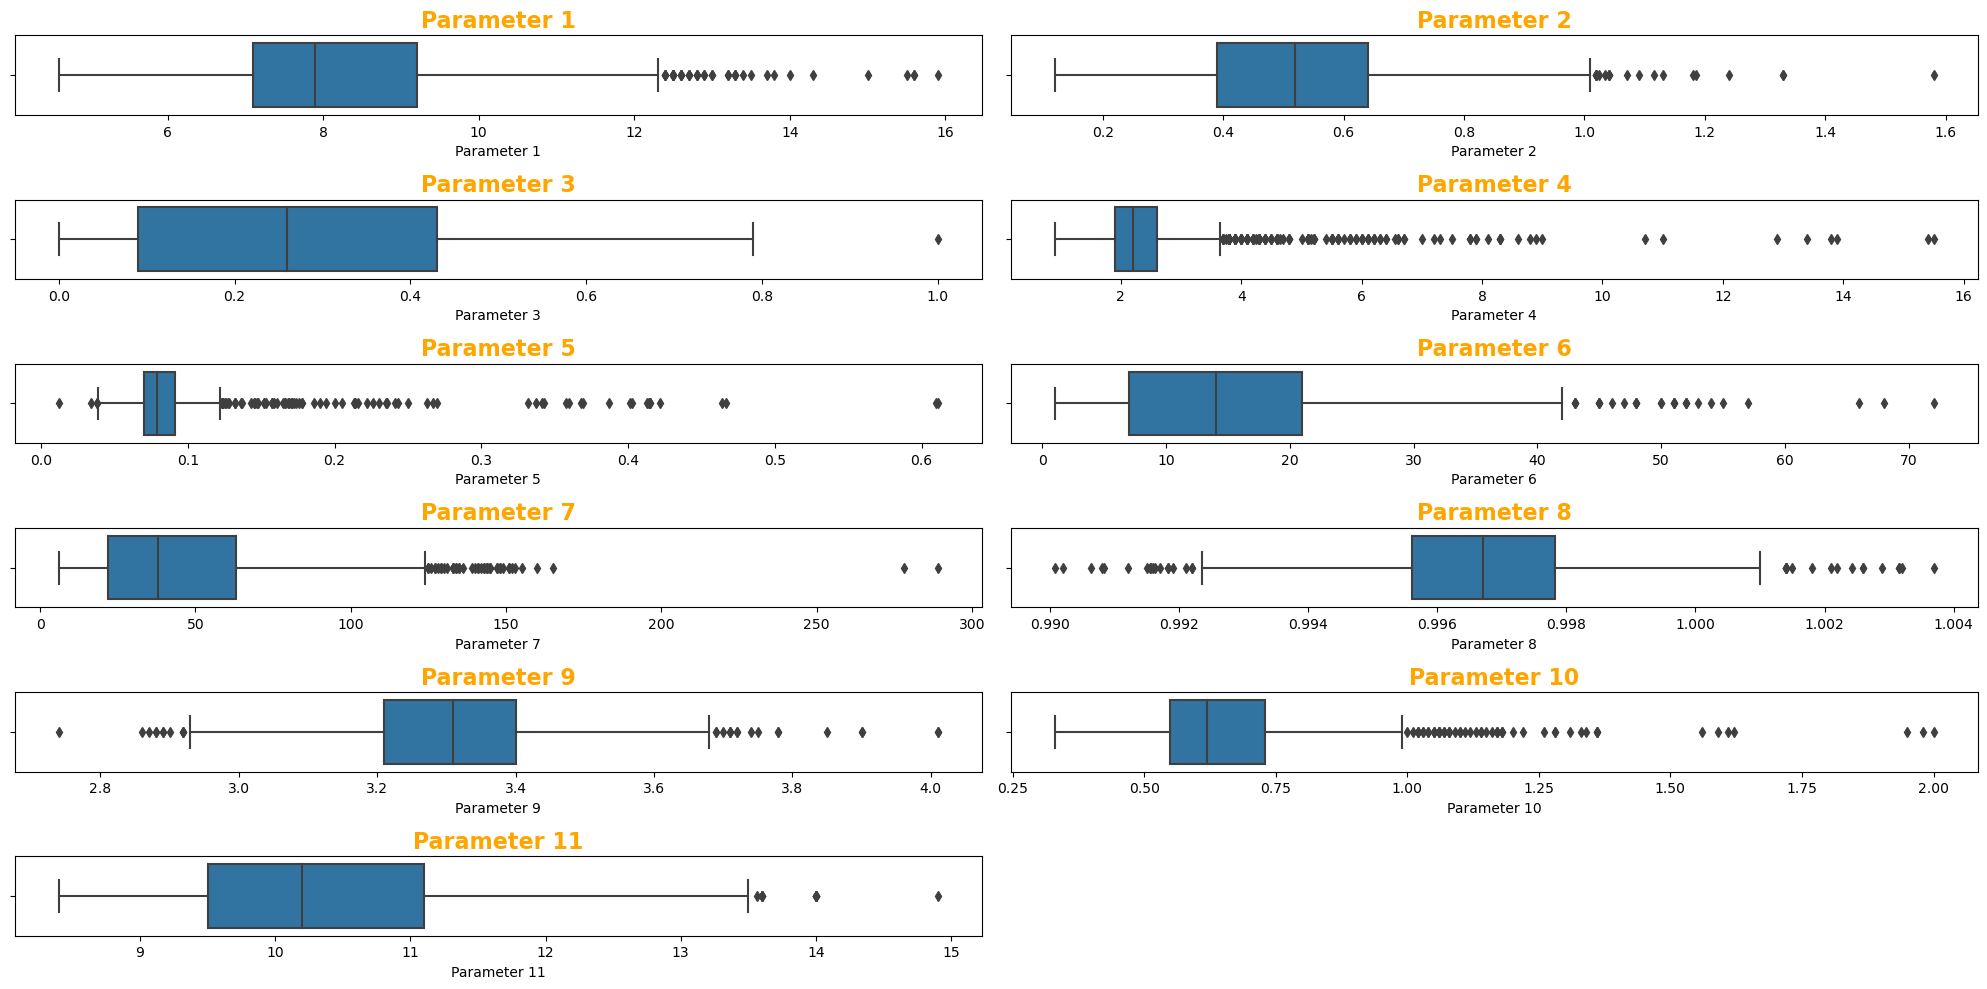

In [15]:
numerical_col=[i for i in signals.columns.drop('Signal_Strength') if is_numeric_dtype(signals[i])]
fig=plt.figure(figsize=(20,10))
for i in range(0,len(numerical_col)):
   ax=fig.add_subplot(6,2,i+1)
   sns.boxplot(data=signals, x=numerical_col[i])
   ax.set_title(numerical_col[i],color='orange',weight='bold',fontsize=16)
plt.tight_layout()
plt.show()

Many outliers are present, will be replacing these outliers.

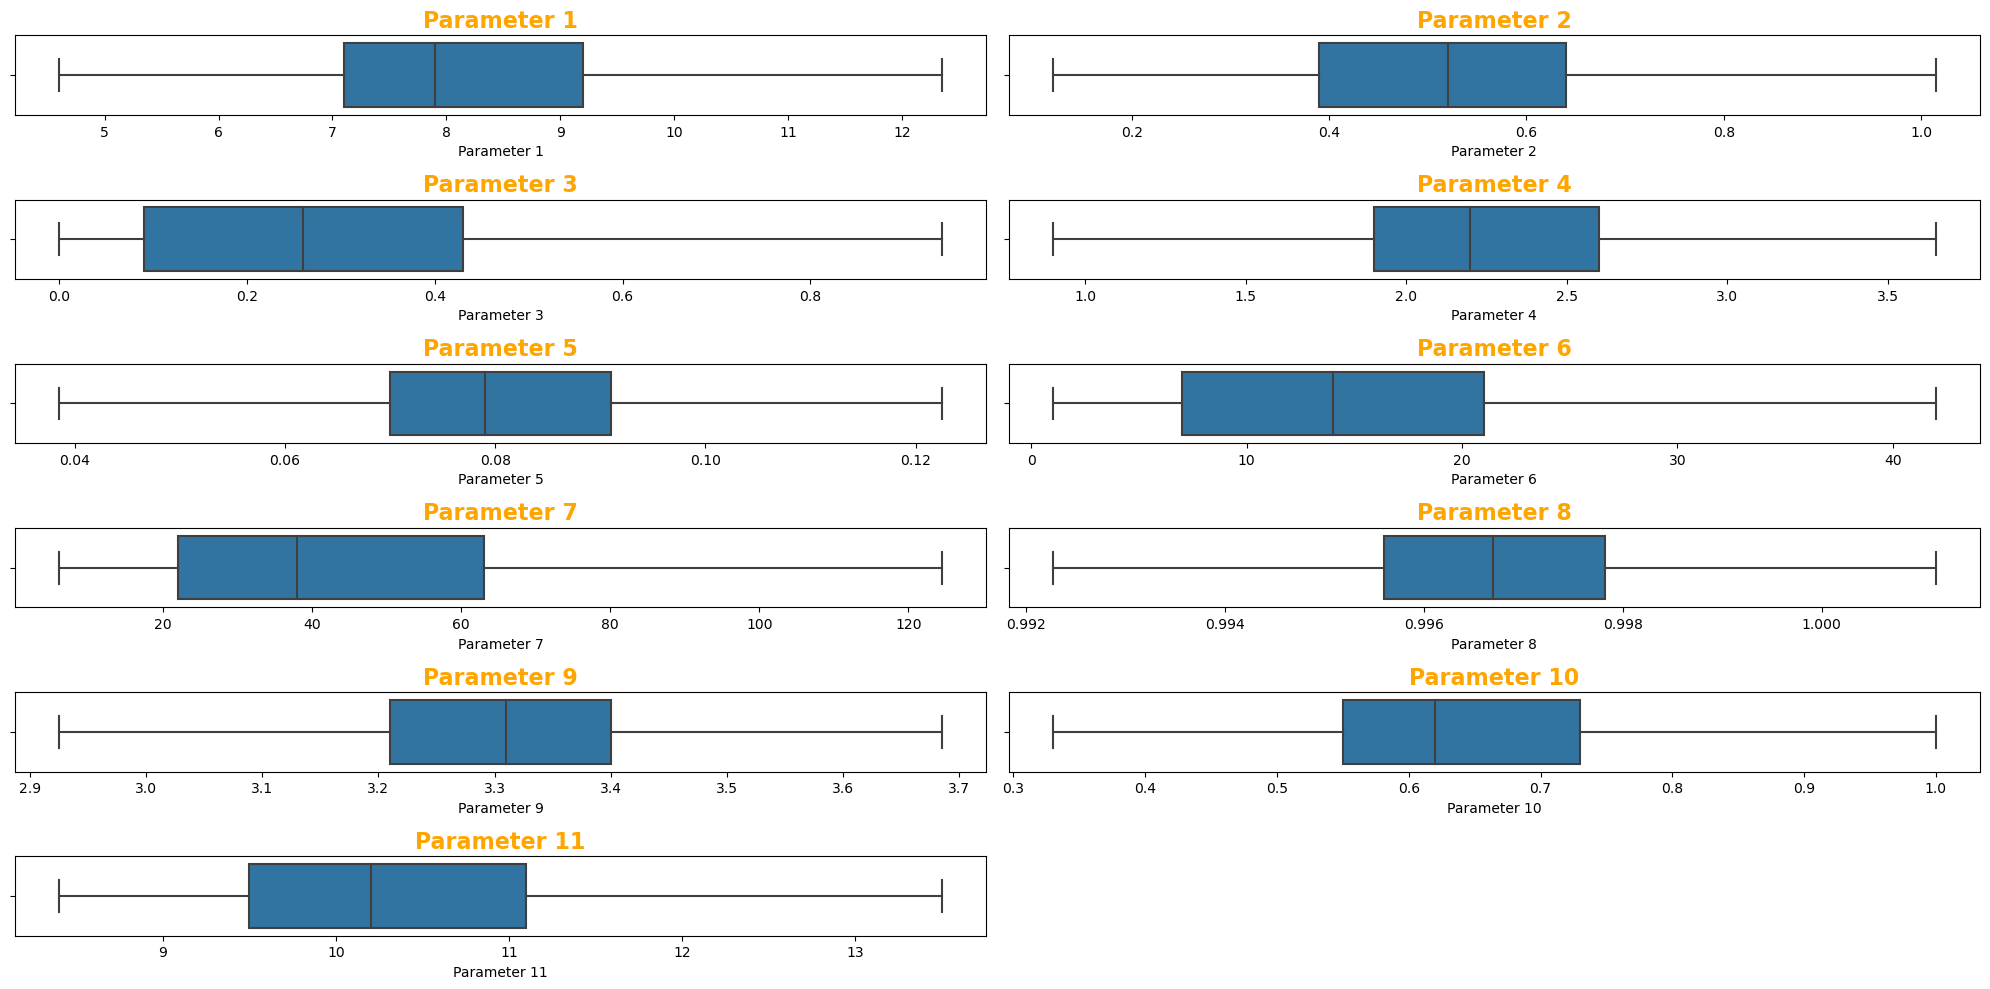

In [16]:
signals_w_outliers=signals.copy(deep=True)

#Treating outliers.
for col_name in signals.columns.drop('Signal_Strength'):
    if is_numeric_dtype(signals[col_name]):
        q1=np.quantile(signals[col_name], 0.25)
        q3=np.quantile(signals[col_name], 0.75)
        cut_off=1.5*(q3-q1)
        right_whisker= q3 + cut_off
        left_whiskers=q1 - cut_off

        #Replace every outlier on the upper side by the upper whisker
        for i in np.where(signals[col_name] > right_whisker)[0]:
            signals.loc[i,col_name] = right_whisker

        #Replace every outlier on the lower side by the lower whisker
        for i in np.where(signals[col_name] < left_whiskers)[0]:
            signals.loc[i,col_name] = left_whiskers

numerical_col=[i for i in signals.columns.drop('Signal_Strength') if is_numeric_dtype(signals[i])]
fig=plt.figure(figsize=(20,10))
for i in range(0,len(numerical_col)):
   ax=fig.add_subplot(6,2,i+1)
   sns.boxplot(data=signals, x=numerical_col[i])
   ax.set_title(numerical_col[i],color='orange',weight='bold',fontsize=16)
plt.tight_layout()
plt.show()

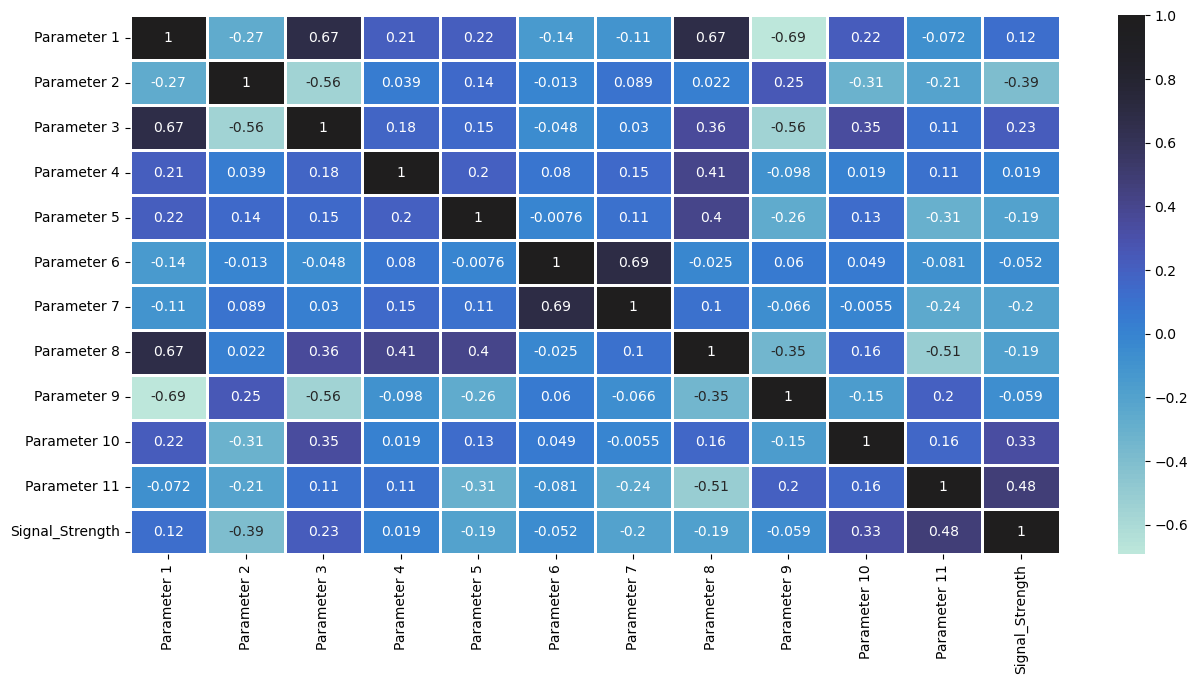

In [17]:
plt.figure(figsize=(15,7))
sns.heatmap(signals.corr(), annot=True,center=True, linewidths=1)
plt.show()

- Some features are correlated as positive and negative correlation.
- Correlation value ranges in between 0.7 and -0.7.

## 2. Data preprocessing

### A. Split the data into X & Y.

In [18]:
X=signals.drop('Signal_Strength',axis=1)
y=signals['Signal_Strength']
X.shape,y.shape

((1359, 11), (1359,))

Signal dataset is split into feature and target variables for further modelling.

### B. Split the data into train & test with 70:30 proportion.
### C. Print shape of all the 4 variables and verify if train and test data is in sync.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=random_state, stratify=y)

In [20]:
print('Feature training dataset have %d records and %d feature'%(X_train.shape[0], X_train.shape[1]))
print('Feature testing dataset have %d records and %d feature'%(X_test.shape[0], X_test.shape[1]))
print('Target training dataset have %d records'%(y_train.shape[0]))
print('Target testing dataset have %d records'%(y_test.shape[0]))

Feature training dataset have 951 records and 11 feature
Feature testing dataset have 408 records and 11 feature
Target training dataset have 951 records
Target testing dataset have 408 records


### D. Normalise the train and test data with appropriate method.

Applying zscore which is
$$
\frac{X-X_{mean}}{X_{std}}
$$

In [21]:
X_train=X_train.apply(zscore)
X_train.head()

Parameter 1  Parameter 2  Parameter 3  Parameter 4  Parameter 5  \
732    -1.109910     0.555085    -0.337200    -1.178133    -0.062214   
672    -0.819939     0.582698    -0.541713     0.124947     2.198027   
376    -0.297991     0.113270     0.378597    -0.200823    -0.381306   
71     -0.877933     1.411101    -1.410895     0.124947     1.214157   
287     1.093872    -0.936040     1.861319     0.939372     2.171436   

     Parameter 6  Parameter 7  Parameter 8  Parameter 9  Parameter 10  \
732    -0.375435    -0.465921     0.102155     1.779210      0.075439   
672    -0.973407    -0.905697    -0.323253     0.608998     -0.431829   
376     0.521523     0.602108     0.376786    -0.366178     -0.649229   
71     -0.176111    -0.528746    -0.054008     1.389139     -0.721696   
287    -0.574759    -0.183207     0.699880    -0.496202      0.075439   

     Parameter 11  
732     -0.579891  
672     -0.117863  
376     -1.134324  
71       0.251759  
287      1.915058

In [22]:
X_test=X_test.apply(zscore)
X_test.head()

Parameter 1  Parameter 2  Parameter 3  Parameter 4  Parameter 5  \
1185    -0.614449     0.393462    -0.019291    -0.550950    -0.095020   
699     -0.412926    -0.262259     0.237928     0.801156    -0.660156   
1001     0.997739    -0.619925     1.009586    -0.381937    -0.434102   
281      1.400786     0.393462     0.803810     0.801156     0.470115   
1306    -1.353369     0.691517    -0.893837     0.294116    -0.038507   

      Parameter 6  Parameter 7  Parameter 8  Parameter 9  Parameter 10  \
1185     0.149752     2.099022    -0.534685    -0.248584     -0.963137   
699     -1.232816    -1.033787     0.126674    -0.676376     -0.742290   
1001    -1.126464    -0.998587    -0.140296    -0.319883      0.656405   
281      2.064077     1.007819     1.382650    -0.248584      0.361943   
1306    -0.062951    -0.646586    -0.813790     1.819077     -0.153366   

      Parameter 11  
1185     -0.510120  
699      -0.126207  
1001      1.793361  
281      -0.894034  
1306      1.505426

### E. Transform Labels into format acceptable by Neural Network.

Target label ranges from 3 to 8, so total number of classes will be as 'max(y)+1` which is 9.

In [23]:
y_cat_train=tf.keras.utils.to_categorical(y_train,num_classes=9)
y_cat_test=tf.keras.utils.to_categorical(y_test,num_classes=9)

In [24]:
print('Target training dataset have %d records and %d feature'%(y_cat_train.shape[0],y_cat_train.shape[1]))
print('Target testing dataset have %d records and %d feature'%(y_cat_test.shape[0],y_cat_test.shape[1]))

Target training dataset have 951 records and 9 feature
Target testing dataset have 408 records and 9 feature


## 3. Model Training & Evaluation using Neural Network.

### A. Design a Neural Network to train a classifier.
### B. Train the classifier using previously designed Architecture.
### C. Plot 2 separate visuals.
- Training Loss and Validation Loss
- Training Accuracy and Validation Accuracy

In [25]:
backend.clear_session()
tf.random.set_seed(random_state)

#Initialize sequenial model
model = Sequential()
model.add(Dense(input_dim=11, units=64,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))

# Add dense layer which provides 8 outputs after applying softmax
model.add(Dense(9, activation='softmax'))

In [26]:
#compile the model
optimizer = tf.keras.optimizers.SGD(0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 9)                 81        
                                                                 
Total params: 2,025
Trainable params: 2,025
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fit the model
history=model.fit(x=X_train, y=y_cat_train, batch_size=20, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
38/38 [==============================] - 1s 9ms/step - loss: 1.9977 - accuracy: 0.3908 - val_loss: 1.9110 - val_accuracy: 0.3927
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 1.7836 - accuracy: 0.4329 - val_loss: 1.7170 - val_accuracy: 0.3874
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 1.6111 - accuracy: 0.4342 - val_loss: 1.5688 - val_accuracy: 0.3874
Epoch 4/100
38/38 [==============================] - 0s 3ms/step - loss: 1.4822 - accuracy: 0.4342 - val_loss: 1.4543 - val_accuracy: 0.3874
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 1.3856 - accuracy: 0.4421 - val_loss: 1.3670 - val_accuracy: 0.4241
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 1.3145 - accuracy: 0.4750 - val_loss: 1.3019 - val_accuracy: 0.4764
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 1.2634 - accuracy: 0.5105 - val_loss: 1.2546 - val_accuracy: 0.5131
Epoch 8/100
3

Epoch 59/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9196 - accuracy: 0.6276 - val_loss: 0.9107 - val_accuracy: 0.6126
Epoch 60/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9176 - accuracy: 0.6303 - val_loss: 0.9109 - val_accuracy: 0.6126
Epoch 61/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9158 - accuracy: 0.6289 - val_loss: 0.9083 - val_accuracy: 0.6126
Epoch 62/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9143 - accuracy: 0.6382 - val_loss: 0.9059 - val_accuracy: 0.6126
Epoch 63/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9115 - accuracy: 0.6329 - val_loss: 0.9142 - val_accuracy: 0.6178
Epoch 64/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9116 - accuracy: 0.6237 - val_loss: 0.9060 - val_accuracy: 0.6178
Epoch 65/100
38/38 [==============================] - 0s 3ms/step - loss: 0.9093 - accuracy: 0.6382 - val_loss: 0.9061 - val_accuracy: 0.6178
Epoch 

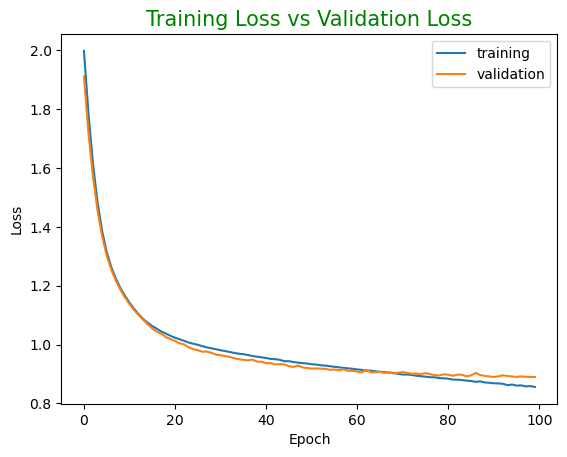

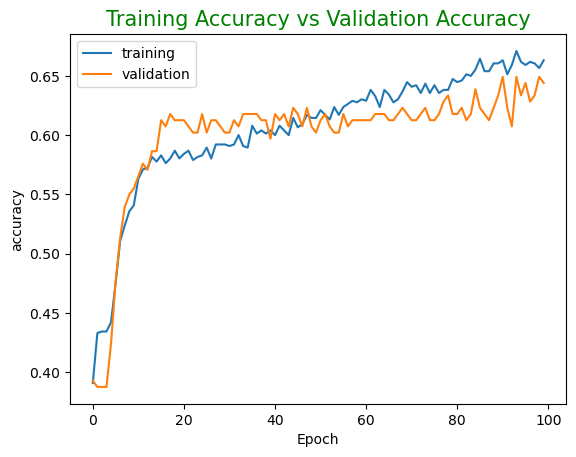

In [29]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting Loss at different epochs
plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

# Plotting Accuracy at different epochs
plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

In [30]:
# calculate score of training data
model.evaluate(X_train, y_cat_train, batch_size=20, verbose=1)

48/48 [==============================] - 0s 1ms/step - loss: 0.8581 - accuracy: 0.6519


[0.8580824136734009, 0.6519452929496765]

In [31]:
# calculate score of testing data
model.evaluate(X_test, y_cat_test, batch_size=20, verbose=1)

21/21 [==============================] - 0s 2ms/step - loss: 0.9738 - accuracy: 0.5809


[0.9737644791603088, 0.5808823704719543]

In [32]:
# Predicting for X_test
y_pred=model.predict(X_test)
y_pred

13/13 [==============================] - 0s 1ms/step


array([[1.9374361e-06, 6.9513757e-05, 3.0812291e-05, ..., 1.4998730e-01,
        2.0264250e-03, 8.8195171e-05],
       [3.5061644e-04, 2.0829607e-03, 8.8139251e-04, ..., 4.1179952e-01,
        3.9620627e-02, 4.5146686e-03],
       [2.1333779e-04, 2.7704018e-04, 1.3851421e-04, ..., 3.1349000e-01,
        6.2052524e-01, 4.3284602e-02],
       ...,
       [4.3199203e-04, 1.1876954e-03, 1.8928554e-04, ..., 3.9976192e-01,
        3.1093350e-01, 2.2049813e-02],
       [2.0673810e-06, 7.9938269e-05, 4.5056448e-05, ..., 3.7442851e-01,
        1.2831197e-02, 3.9829564e-04],
       [3.5760399e-06, 9.7782715e-05, 4.6790516e-05, ..., 1.9788137e-01,
        2.6948268e-03, 1.3410010e-04]], dtype=float32)

In [33]:
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))
print(y_pred_final)

[5, 5, 7, 5, 6, 5, 5, 6, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5, 7, 5, 6, 6, 5, 5, 7, 5, 6, 6, 5, 5, 5, 5, 6, 7, 5, 5, 7, 5, 6, 5, 7, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 5, 5, 5, 7, 6, 6, 5, 7, 5, 6, 5, 6, 6, 6, 5, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 5, 7, 6, 5, 6, 6, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 7, 5, 5, 6, 6, 5, 6, 7, 6, 5, 7, 6, 6, 7, 6, 5, 5, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 7, 6, 5, 5, 5, 6, 5, 5, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 7, 5, 5, 5, 6, 6, 6, 5, 5, 6, 6, 5, 5, 6, 5, 6, 6, 5, 7, 6, 5, 6, 5, 5, 6, 5, 6, 7, 7, 6, 6, 6, 6, 5, 6, 5, 5, 6, 6, 6, 6, 7, 5, 7, 6, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 5, 5, 7, 6, 5, 7, 5, 5, 5, 7, 5, 5, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 5, 6, 6, 6, 6, 5, 6, 5, 5, 7, 6, 5, 6, 5, 6, 6, 6, 5, 5, 6, 5, 5, 7, 6, 5, 5, 5, 7, 6, 5, 5, 7, 5, 5, 6, 6, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 5, 6, 7, 5, 7, 5, 5, 5, 7, 5, 7, 7, 7, 6, 5, 5, 7, 6, 6, 5, 5, 5, 6, 6, 5, 6, 6, 

In [34]:
print('Classification Report')
print(classification_report(y_test,y_pred_final))

Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.64      0.72      0.68       173
           6       0.54      0.58      0.56       161
           7       0.47      0.40      0.43        50
           8       0.00      0.00      0.00         5

    accuracy                           0.58       408
   macro avg       0.27      0.28      0.28       408
weighted avg       0.54      0.58      0.56       408



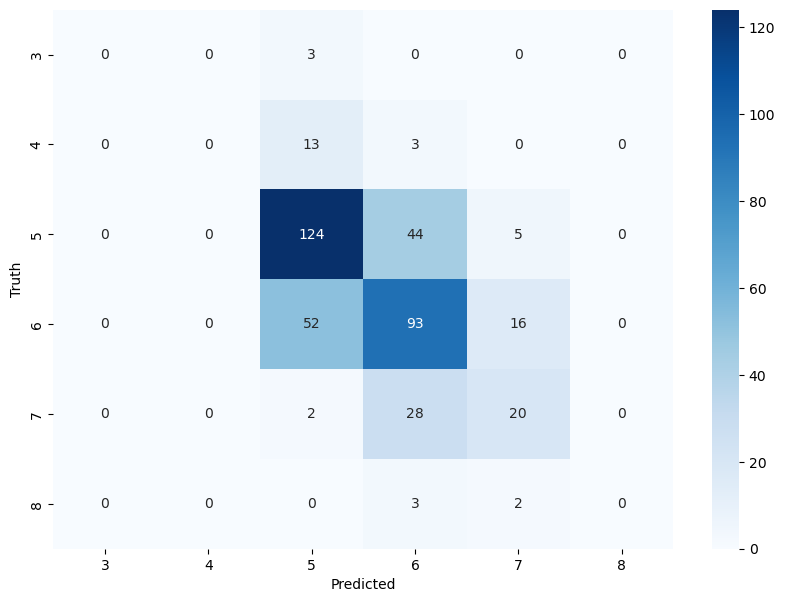

In [35]:
cm=confusion_matrix(y_test.tolist(),y_pred_final)

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### D. Design new architecture/update existing architecture in attempt to improve the performance of the model.
### E. Plot visuals as in Q3.C and share insights about difference observed in both the models.

Tuning params using Keras Tuner.

In [36]:
backend.clear_session()
tf.random.set_seed(random_state)

def build_model(h):
    model_keras = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 5)):
        model_keras.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=10),
                               activation=h.Choice('act_' + str(i), ['relu', 'sigmoid'])))
    model_keras.add(layers.Dense(9, activation='softmax'))
    model_keras.compile(
        optimizer=keras.optimizers.SGD(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model_keras

In [37]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
     project_name='Job_')

INFO:tensorflow:Reloading Tuner from .\Job_\tuner0.json


In [38]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 10, 'sampling': 'linear'}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 10, 'sampling': 'linear'}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 10, 'sampling': 'linear'}
act_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_3 (Int)
{'default': None, 'conditions': [], 'm

In [39]:
### Searching the best model on X and y train
tuner.search(X_train, y_cat_train,
             epochs=100,
             validation_split = 0.2, verbose=1)

INFO:tensorflow:Oracle triggered exit


In [40]:
## Printing the best models with their hyperparameters
tuner.results_summary()

Results summary
Results in .\Job_
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 4
units_0: 202
act_0: relu
units_1: 212
act_1: relu
learning_rate: 0.01
units_2: 112
act_2: sigmoid
units_3: 182
act_3: sigmoid
units_4: 212
act_4: sigmoid
Score: 0.6108202338218689
Trial summary
Hyperparameters:
num_layers: 5
units_0: 202
act_0: sigmoid
units_1: 162
act_1: relu
learning_rate: 0.0001
units_2: 32
act_2: relu
units_3: 32
act_3: relu
units_4: 32
act_4: relu
Score: 0.4624781807263692
Trial summary
Hyperparameters:
num_layers: 5
units_0: 62
act_0: sigmoid
units_1: 82
act_1: sigmoid
learning_rate: 0.0001
units_2: 112
act_2: sigmoid
units_3: 52
act_3: sigmoid
units_4: 152
act_4: sigmoid
Score: 0.4589877724647522
Trial summary
Hyperparameters:
num_layers: 5
units_0: 172
act_0: relu
units_1: 92
act_1: sigmoid
learning_rate: 0.001
units_2: 182
act_2: relu
units_3: 122
act_3: sigmoid
units_4: 122
act_4: relu
Score: 0.4031413495540619
Trial summary
Hyperparameters:
num_layers: 3
uni

In [41]:
backend.clear_session()
tf.random.set_seed(random_state)

model_keras = Sequential()

model_keras.add(Dense(202,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model_keras.add(Dense(212,activation='relu',kernel_initializer='he_uniform'))
model_keras.add(Dense(112,activation='sigmoid',kernel_initializer='he_uniform'))
model_keras.add(Dense(182,activation='sigmoid',kernel_initializer='he_uniform'))
model_keras.add(Dense(212,activation='sigmoid',kernel_initializer='he_uniform'))

model_keras.add(layers.Dense(9, activation='softmax'))

In [42]:
optimizer = tf.keras.optimizers.SGD(0.01)
model_keras.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [43]:
model_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 202)               2424      
                                                                 
 dense_1 (Dense)             (None, 212)               43036     
                                                                 
 dense_2 (Dense)             (None, 112)               23856     
                                                                 
 dense_3 (Dense)             (None, 182)               20566     
                                                                 
 dense_4 (Dense)             (None, 212)               38796     
                                                                 
 dense_5 (Dense)             (None, 9)                 1917      
                                                                 
Total params: 130,595
Trainable params: 130,595
Non-trai

In [44]:
history_keras = model_keras.fit(x=X_train, y=y_cat_train, batch_size=20, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
38/38 [==============================] - 1s 9ms/step - loss: 1.4809 - accuracy: 0.3895 - val_loss: 1.2525 - val_accuracy: 0.3874
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 1.2533 - accuracy: 0.4276 - val_loss: 1.2252 - val_accuracy: 0.3874
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 1.2377 - accuracy: 0.4171 - val_loss: 1.2120 - val_accuracy: 0.3874
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 1.2305 - accuracy: 0.4184 - val_loss: 1.1957 - val_accuracy: 0.4346
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 1.2276 - accuracy: 0.4237 - val_loss: 1.1887 - val_accuracy: 0.4293
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 1.2208 - accuracy: 0.4237 - val_loss: 1.1842 - val_accuracy: 0.5079
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 1.2214 - accuracy: 0.4289 - val_loss: 1.1911 - val_accuracy: 0.3874
Epoch 8/100
3

Epoch 59/100
38/38 [==============================] - 0s 4ms/step - loss: 1.0151 - accuracy: 0.5737 - val_loss: 0.9682 - val_accuracy: 0.6021
Epoch 60/100
38/38 [==============================] - 0s 3ms/step - loss: 1.0105 - accuracy: 0.5855 - val_loss: 0.9647 - val_accuracy: 0.5969
Epoch 61/100
38/38 [==============================] - 0s 3ms/step - loss: 1.0099 - accuracy: 0.5921 - val_loss: 0.9611 - val_accuracy: 0.5916
Epoch 62/100
38/38 [==============================] - 0s 3ms/step - loss: 1.0052 - accuracy: 0.5921 - val_loss: 0.9615 - val_accuracy: 0.6073
Epoch 63/100
38/38 [==============================] - 0s 4ms/step - loss: 1.0042 - accuracy: 0.5895 - val_loss: 0.9714 - val_accuracy: 0.5916
Epoch 64/100
38/38 [==============================] - 0s 3ms/step - loss: 1.0021 - accuracy: 0.5789 - val_loss: 0.9556 - val_accuracy: 0.5916
Epoch 65/100
38/38 [==============================] - 0s 3ms/step - loss: 1.0005 - accuracy: 0.5921 - val_loss: 0.9552 - val_accuracy: 0.6021
Epoch 

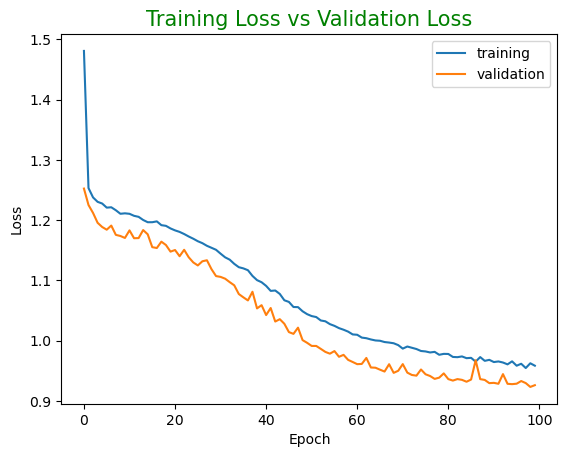

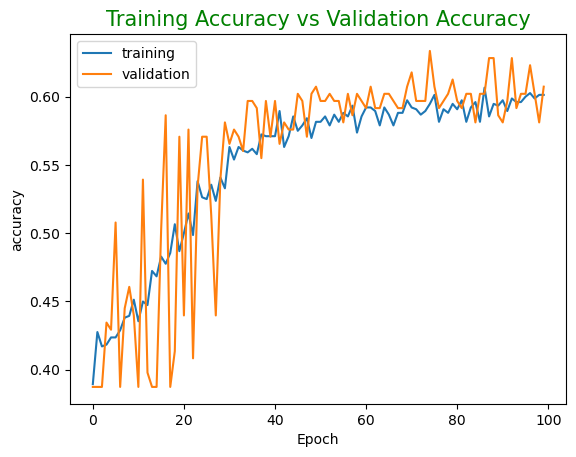

In [45]:
# Capturing learning history per epoch
hist_keras  = pd.DataFrame(history_keras.history)
hist_keras['epoch'] = history_keras.epoch

# Plotting Loss at different epochs
plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
plt.plot(hist_keras['loss'])
plt.plot(hist_keras['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

# Plotting Accuracy at different epochs
plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
plt.plot(hist_keras['accuracy'])
plt.plot(hist_keras['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

In [46]:
# calculate score of training data
model_keras.evaluate(X_train, y_cat_train, batch_size=20, verbose=1)

48/48 [==============================] - 0s 2ms/step - loss: 0.9469 - accuracy: 0.6078


[0.9469315409660339, 0.6077812910079956]

In [47]:
# calculate score of testing data
model_keras.evaluate(X_test, y_cat_test, batch_size=20, verbose=1)

21/21 [==============================] - 0s 2ms/step - loss: 1.0047 - accuracy: 0.5931


[1.0047204494476318, 0.593137264251709]

In [48]:
# Predicting for X_test
y_pred_keras = model_keras.predict(X_test)
y_pred_keras

13/13 [==============================] - 0s 2ms/step


array([[1.8887123e-04, 1.6787344e-04, 1.3803072e-04, ..., 1.8187954e-01,
        9.0554105e-03, 4.5836507e-03],
       [2.9591320e-04, 2.8368965e-04, 2.4793879e-04, ..., 3.2496709e-01,
        3.1332456e-02, 9.5211444e-03],
       [2.2973996e-04, 2.1991009e-04, 2.7420151e-04, ..., 4.6292165e-01,
        4.5346698e-01, 2.4619879e-02],
       ...,
       [3.2492119e-04, 3.2192259e-04, 3.5399600e-04, ..., 5.5859345e-01,
        2.6717067e-01, 2.3405660e-02],
       [3.5693907e-04, 3.3271729e-04, 3.3872898e-04, ..., 4.6509126e-01,
        7.1178176e-02, 1.5960392e-02],
       [2.1294493e-04, 1.9088805e-04, 1.5998697e-04, ..., 2.1068053e-01,
        1.1996112e-02, 5.5889399e-03]], dtype=float32)

In [49]:
y_pred_keras_final = []
for i in y_pred_keras:
    y_pred_keras_final.append(np.argmax(i))
print(y_pred_keras_final)

[5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 7, 5, 6, 6, 5, 6, 5, 5, 6, 7, 5, 5, 7, 5, 6, 5, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 5, 5, 5, 7, 6, 6, 5, 6, 5, 6, 5, 6, 6, 6, 5, 6, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 6, 5, 7, 5, 5, 6, 6, 5, 6, 6, 6, 5, 7, 5, 6, 7, 6, 5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 6, 6, 5, 6, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 6, 5, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 7, 6, 5, 6, 5, 5, 6, 5, 6, 6, 7, 6, 6, 6, 6, 5, 6, 5, 5, 6, 6, 6, 6, 6, 5, 7, 6, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 7, 5, 5, 5, 6, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 6, 6, 6, 6, 5, 5, 5, 5, 7, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 5, 5, 6, 6, 5, 5, 5, 6, 6, 5, 5, 7, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 5, 6, 6, 5, 7, 5, 5, 5, 7, 5, 6, 6, 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 6, 6, 5, 6, 5, 

In [50]:
print('Classification Report')
print(classification_report(y_test, y_pred_keras_final))

Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.65      0.76      0.70       173
           6       0.53      0.63      0.58       161
           7       0.56      0.18      0.27        50
           8       0.00      0.00      0.00         5

    accuracy                           0.59       408
   macro avg       0.29      0.26      0.26       408
weighted avg       0.56      0.59      0.56       408



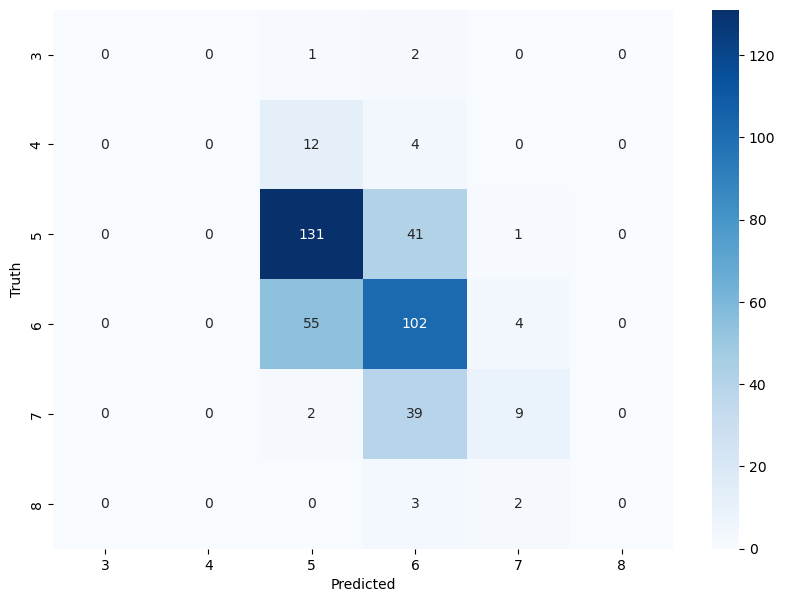

In [51]:
cm = confusion_matrix(y_test.tolist(), y_pred_keras_final)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[3, 4, 5, 6, 7, 8], yticklabels=[3, 4, 5, 6, 7, 8])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

- After tuning hyperparameters, both accuracy for train and test dataset have been closer.
- Different techniques can be used for tunning and more improvement techniques can be used like, Dropout, weight initialization, regularization and more.
- Change in confusion matrix, with increased f1-score values for some labels(5,6) with drop in another label(7).

################################

# PART-B

################################

## 1. Data Import and Exploration

### A. Read the .h5 file and assign to a variable.

In [52]:
# svhn_hf=h5py.File('/content/drive/MyDrive/GL/Autonomous_Vehicles_SVHN_single_grey1.h5','r')
svhn_hf = h5py.File('Autonomous_Vehicles_SVHN_single_grey1.h5', 'r')
svhn_hf

<HDF5 file "Autonomous_Vehicles_SVHN_single_grey1.h5" (mode r)>

### B. Print all the keys from the .h5 file.

In [53]:
svhn_hf.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

Different keys are present, i.e.:
- Train dataset:
    - X_train
    - X_val
    - y_train
- Test dataset:
    - X_test
    - y_test
    - y_val

### C. Split the data into X_train, X_test, Y_train, Y_test

In [54]:
X_svhn_train = svhn_hf['X_train'][:]
y_svhn_train = svhn_hf['y_train'][:]
X_svhn_val = svhn_hf['X_val'][:]
X_svhn_test = svhn_hf['X_test'][:]
y_svhn_test = svhn_hf['y_test'][:]
y_svhn_val = svhn_hf['y_val'][:]

svhn_hf.close()

## 2. Data Visualisation and preprocessing

### A. Print shape of all the 4 data split into x, y, train, test to verify if x & y is in sync.

In [55]:
print('X_train:', X_svhn_train.shape)
print('y_train:', y_svhn_train.shape)
print('X_test:', X_svhn_test.shape)
print('y_test:', y_svhn_test.shape)
print('X_val:', X_svhn_val.shape)
print('y_val:', y_svhn_val.shape)

X_train: (42000, 32, 32)
y_train: (42000,)
X_test: (18000, 32, 32)
y_test: (18000,)
X_val: (60000, 32, 32)
y_val: (60000,)


All datasets are in sync with records and features for all train, test and val set.

### B. Visualise first 10 images in train data and print its corresponding labels.

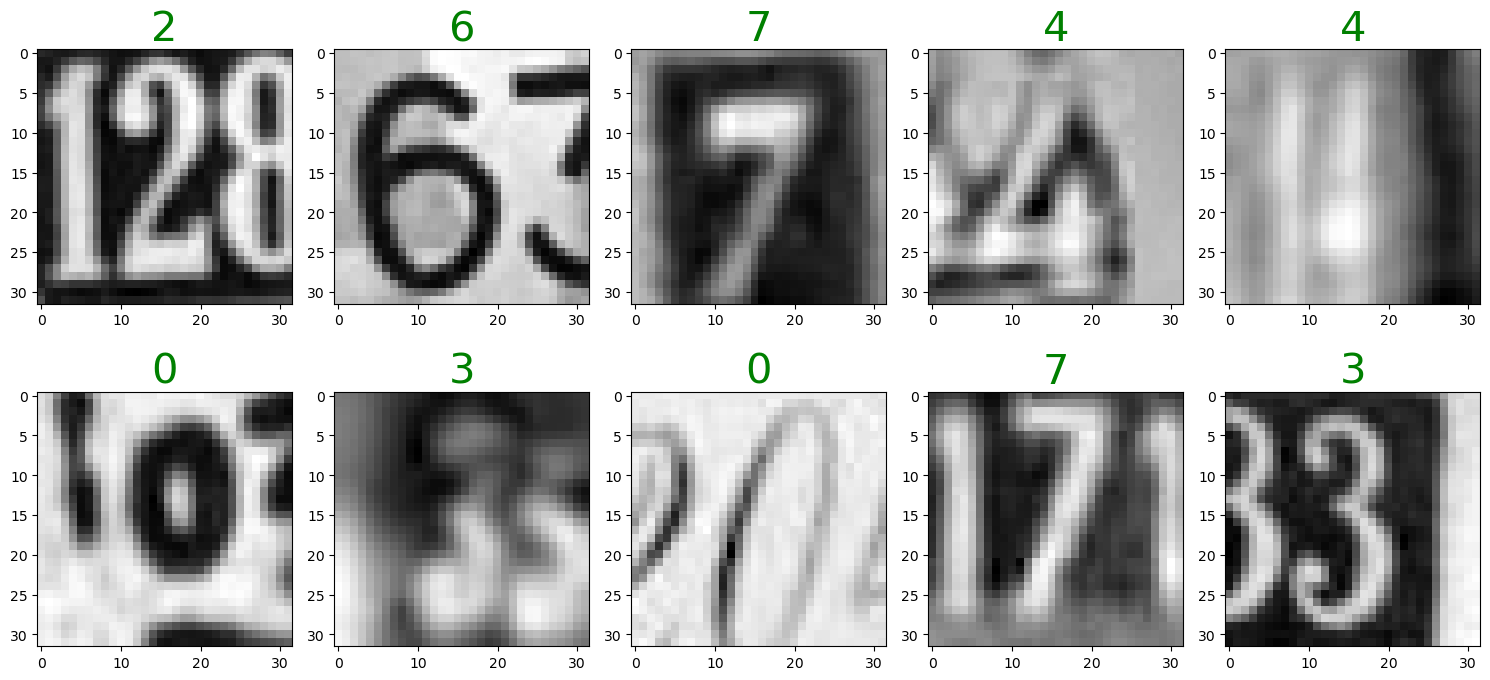

In [56]:
fig=plt.figure(figsize=(15,7))
for i in range(0,10):
   ax=fig.add_subplot(2,5,i+1)
   plt.title(y_svhn_train[i], fontsize=30, color="green") #labels
   plt.imshow(X_svhn_train[i], cmap='gray')
plt.tight_layout()
plt.show()

### C. Reshape all the images with appropriate shape update the data in same variable.

In [57]:
X_svhn_train=X_svhn_train.reshape(X_svhn_train.shape[0], -1)
X_svhn_test=X_svhn_test.reshape(X_svhn_test.shape[0], -1)
X_svhn_val=X_svhn_val.reshape(X_svhn_val.shape[0], -1)

In [58]:
print('X_train:', X_svhn_train.shape)
print('X_test:', X_svhn_test.shape)
print('X_val:', X_svhn_val.shape)

X_train: (42000, 1024)
X_test: (18000, 1024)
X_val: (60000, 1024)


### D. Normalise the images i.e. Normalise the pixel values.

In [59]:
#As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1.
X_svhn_train=X_svhn_train.astype('float32')/255.0
X_svhn_test=X_svhn_test.astype('float32')/255.0
X_svhn_val=X_svhn_val.astype('float32')/255.0

### E. Transform Labels into format acceptable by Neural Network

In [60]:
# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_svhn_train = to_categorical(y_svhn_train, num_classes)
y_svhn_val = to_categorical(y_svhn_val, num_classes)
y_svhn_test_cat=to_categorical(y_svhn_test,num_classes)

print('y_train:', y_svhn_train.shape)
print('y_test_cat:', y_svhn_test_cat.shape)
print('y_val:', y_svhn_val.shape)

y_train: (42000, 10)
y_test_cat: (18000, 10)
y_val: (60000, 10)


### F. Print total Number of classes in the Dataset.

In [61]:
print('X_train:', X_svhn_train.shape)
print('y_train:', y_svhn_train.shape)
print('X_test:', X_svhn_test.shape)
print('y_test:', y_svhn_test_cat.shape)
print('X_val:', X_svhn_val.shape)
print('y_val:', y_svhn_val.shape)

X_train: (42000, 1024)
y_train: (42000, 10)
X_test: (18000, 1024)
y_test: (18000, 10)
X_val: (60000, 1024)
y_val: (60000, 10)


In [62]:
#Classes present for target class
print(pd.DataFrame(y_svhn_train).columns)

RangeIndex(start=0, stop=10, step=1)


Classes are present for : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

## 3. Model Training & Evaluation using Neural Network

### A. Design a Neural Network to train a classifier.
### B. Train the classifier using previously designed Architecture (Use best suitable parameters).
### C. Evaluate performance of the model with appropriate metrics.
### D. Plot the training loss, validation loss vs number of epochs and training accuracy, validation accuracy vs number of epochs plot and write your observations on the same.

In [63]:
backend.clear_session()
tf.random.set_seed(random_state)

# create model
svhn_model = Sequential()

svhn_model.add(Dense(256, activation='relu',kernel_initializer='he_normal',input_shape=(32*32,))) ###Multiple Dense units with Relu activation
svhn_model.add(BatchNormalization())
svhn_model.add(Dense(128, activation='relu',kernel_initializer='he_normal'))
svhn_model.add(BatchNormalization())
svhn_model.add(Dense(64, activation='relu',kernel_initializer='he_normal'))
svhn_model.add(BatchNormalization())
svhn_model.add(Dense(64, activation='relu',kernel_initializer='he_normal'))
svhn_model.add(BatchNormalization())
svhn_model.add(Dense(32, activation='relu',kernel_initializer='he_normal'))
svhn_model.add(BatchNormalization())

svhn_model.add(Dense(num_classes,activation='softmax')) ### For multiclass classification Softmax is used

# Compile model
adam = optimizers.Adam(learning_rate=1e-5)
svhn_model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy']) ### Loss function = Categorical cross entropy

In [64]:
## Looking into our base model
svhn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

In [65]:
# Fit the model
svhn_history=svhn_model.fit(X_svhn_train, y_svhn_train, validation_data=(X_svhn_val, y_svhn_val) , epochs=100, batch_size=100, verbose=1)

Epoch 1/100
420/420 [==============================] - 7s 12ms/step - loss: 2.7065 - accuracy: 0.1136 - val_loss: 2.4908 - val_accuracy: 0.1268
Epoch 2/100
420/420 [==============================] - 4s 10ms/step - loss: 2.5273 - accuracy: 0.1406 - val_loss: 2.4866 - val_accuracy: 0.1575
Epoch 3/100
420/420 [==============================] - 4s 11ms/step - loss: 2.4153 - accuracy: 0.1671 - val_loss: 2.3666 - val_accuracy: 0.1813
Epoch 4/100
420/420 [==============================] - 4s 10ms/step - loss: 2.3139 - accuracy: 0.1942 - val_loss: 2.2806 - val_accuracy: 0.2086
Epoch 5/100
420/420 [==============================] - 4s 10ms/step - loss: 2.2250 - accuracy: 0.2225 - val_loss: 2.1843 - val_accuracy: 0.2371
Epoch 6/100
420/420 [==============================] - 4s 10ms/step - loss: 2.1448 - accuracy: 0.2526 - val_loss: 2.1061 - val_accuracy: 0.2640
Epoch 7/100
420/420 [==============================] - 4s 10ms/step - loss: 2.0655 - accuracy: 0.2799 - val_loss: 2.0279 - val_accuracy:

420/420 [==============================] - 5s 12ms/step - loss: 0.8473 - accuracy: 0.7392 - val_loss: 0.8076 - val_accuracy: 0.7545
Epoch 58/100
420/420 [==============================] - 5s 12ms/step - loss: 0.8391 - accuracy: 0.7406 - val_loss: 0.8093 - val_accuracy: 0.7533
Epoch 59/100
420/420 [==============================] - 5s 12ms/step - loss: 0.8365 - accuracy: 0.7432 - val_loss: 0.8062 - val_accuracy: 0.7537
Epoch 60/100
420/420 [==============================] - 5s 12ms/step - loss: 0.8297 - accuracy: 0.7430 - val_loss: 0.7930 - val_accuracy: 0.7590
Epoch 61/100
420/420 [==============================] - 5s 12ms/step - loss: 0.8257 - accuracy: 0.7447 - val_loss: 0.8002 - val_accuracy: 0.7553
Epoch 62/100
420/420 [==============================] - 5s 12ms/step - loss: 0.8175 - accuracy: 0.7474 - val_loss: 0.7889 - val_accuracy: 0.7585
Epoch 63/100
420/420 [==============================] - 5s 12ms/step - loss: 0.8109 - accuracy: 0.7491 - val_loss: 0.7885 - val_accuracy: 0.759

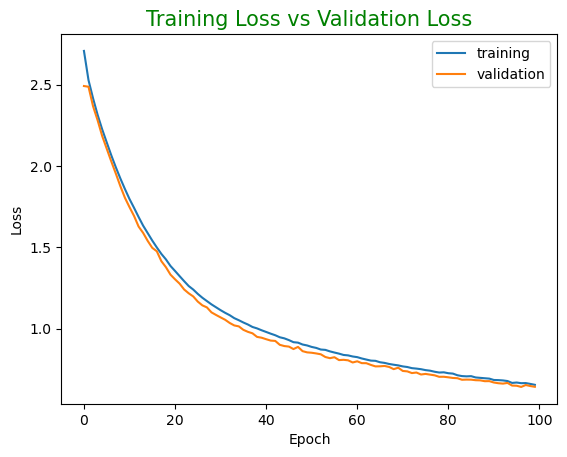

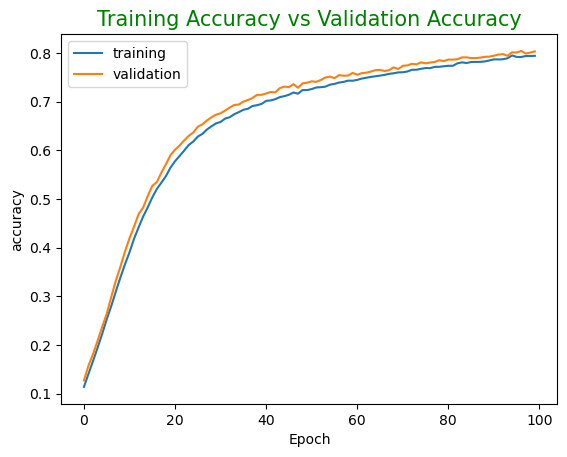

In [66]:
# Capturing learning history per epoch
svhn_hist  = pd.DataFrame(svhn_history.history)
svhn_hist['epoch'] = svhn_history.epoch

# Plotting Loss at different epochs
plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
plt.plot(svhn_hist['loss'])
plt.plot(svhn_hist['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

# Plotting Accuracy at different epochs
plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
plt.plot(svhn_hist['accuracy'])
plt.plot(svhn_hist['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(("training" , "validation") , loc ='best')
plt.show()

In [67]:
# calculate score of training data
svhn_model.evaluate(X_svhn_train, y_svhn_train, batch_size=100, verbose=1)

420/420 [==============================] - 1s 3ms/step - loss: 0.5871 - accuracy: 0.8202


[0.5870670676231384, 0.8201666474342346]

In [68]:
# calculate score of testing data
svhn_model.evaluate(X_svhn_test, y_svhn_test_cat, batch_size=100, verbose=1)

180/180 [==============================] - 0s 3ms/step - loss: 0.7751 - accuracy: 0.7642


[0.7750727534294128, 0.7642222046852112]

In [69]:
# Predicting for X_test
y_svhn_pred=svhn_model.predict(X_svhn_test)
y_svhn_pred

563/563 [==============================] - 1s 2ms/step


array([[3.4577098e-01, 1.6166454e-02, 3.1618235e-01, ..., 9.2613786e-02,
        6.2088434e-02, 1.2856001e-01],
       [4.1881553e-04, 8.6624026e-03, 4.6452436e-01, ..., 5.0947154e-01,
        8.3934190e-04, 5.9603684e-04],
       [1.2797548e-04, 5.8346872e-05, 9.9713898e-01, ..., 1.3466383e-03,
        6.6302385e-04, 7.9395650e-05],
       ...,
       [1.3367975e-03, 5.4388600e-03, 1.0670007e-03, ..., 9.9128717e-01,
        2.4241621e-05, 1.4755127e-04],
       [1.7010840e-02, 9.5398095e-04, 8.0615020e-04, ..., 5.0044339e-04,
        5.5240942e-03, 9.6345818e-01],
       [6.2140054e-04, 1.1670088e-03, 9.7285199e-01, ..., 5.0526974e-03,
        1.5521442e-03, 1.2643705e-03]], dtype=float32)

In [70]:
y_svhn_pred_final=[]
for i in y_svhn_pred:
  y_svhn_pred_final.append(np.argmax(i))
print(y_svhn_pred_final)

[0, 7, 2, 9, 0, 9, 1, 5, 1, 4, 8, 3, 4, 4, 5, 5, 8, 6, 4, 5, 0, 6, 5, 8, 2, 3, 0, 2, 9, 5, 2, 8, 9, 1, 0, 9, 5, 3, 3, 7, 0, 4, 2, 4, 9, 4, 2, 8, 8, 3, 5, 3, 7, 1, 4, 8, 4, 1, 2, 9, 0, 1, 5, 9, 9, 2, 2, 1, 8, 8, 9, 8, 3, 8, 4, 5, 2, 8, 6, 5, 5, 4, 2, 8, 2, 4, 0, 9, 9, 5, 6, 2, 0, 1, 0, 7, 6, 4, 8, 7, 7, 7, 3, 2, 1, 4, 9, 6, 1, 4, 1, 0, 9, 0, 8, 4, 4, 1, 0, 9, 6, 3, 9, 0, 5, 0, 2, 5, 6, 1, 6, 6, 6, 9, 4, 9, 8, 8, 6, 4, 7, 2, 3, 5, 5, 0, 0, 0, 9, 8, 3, 8, 8, 9, 4, 4, 8, 4, 7, 7, 0, 6, 2, 8, 9, 2, 7, 9, 7, 1, 5, 2, 9, 0, 4, 5, 1, 1, 5, 5, 3, 2, 9, 0, 1, 9, 0, 3, 8, 9, 6, 8, 4, 9, 3, 2, 7, 8, 6, 3, 3, 5, 2, 9, 0, 2, 1, 8, 2, 8, 9, 5, 2, 0, 2, 9, 0, 2, 0, 9, 5, 1, 1, 4, 8, 9, 6, 0, 9, 3, 3, 8, 8, 3, 0, 8, 6, 7, 7, 3, 8, 7, 7, 3, 9, 0, 8, 4, 1, 3, 3, 1, 0, 1, 5, 7, 0, 0, 8, 2, 4, 6, 4, 9, 7, 7, 9, 1, 6, 2, 9, 4, 5, 0, 0, 7, 7, 0, 0, 9, 6, 3, 7, 7, 8, 6, 3, 2, 5, 2, 5, 4, 3, 0, 9, 1, 4, 5, 5, 5, 9, 7, 7, 3, 5, 0, 8, 3, 1, 4, 8, 6, 0, 3, 3, 2, 6, 7, 0, 1, 0, 6, 5, 4, 2, 1, 0, 7, 7, 0, 6, 3, 8, 

In [71]:
print('Classification Report')
print(classification_report(y_svhn_test,y_svhn_pred_final))

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1814
           1       0.77      0.80      0.79      1828
           2       0.74      0.78      0.76      1803
           3       0.71      0.72      0.71      1719
           4       0.81      0.80      0.81      1812
           5       0.76      0.70      0.73      1768
           6       0.76      0.76      0.76      1832
           7       0.81      0.82      0.82      1808
           8       0.74      0.72      0.73      1812
           9       0.77      0.73      0.75      1804

    accuracy                           0.76     18000
   macro avg       0.76      0.76      0.76     18000
weighted avg       0.76      0.76      0.76     18000



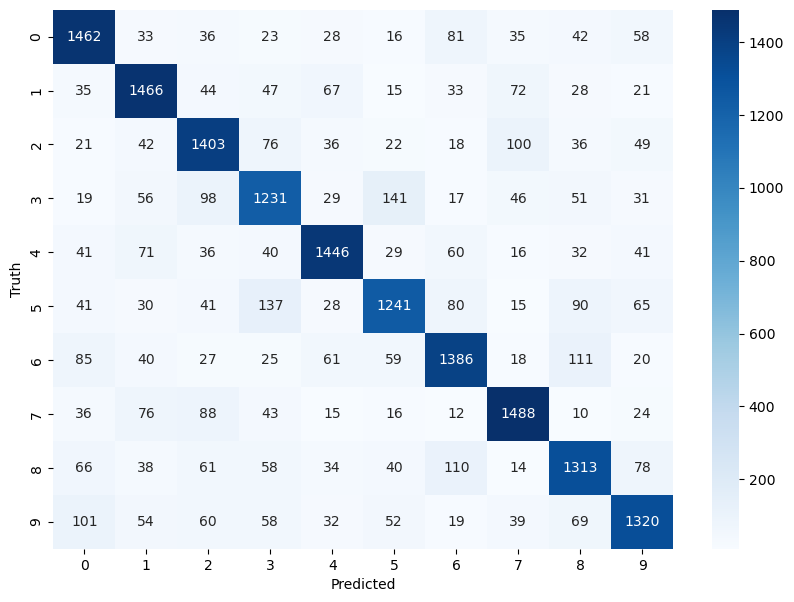

In [72]:
cm=confusion_matrix(y_svhn_test.tolist(),y_svhn_pred_final)

plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

- Validation loss and training loss has been decreasing over epochs.
- Validation accuracy and training accuracy has been increasing over epochs.
- With different hyperparameter tuning and other mechanism tuning can be used for better metrics and results.
- To get more data, we can use data augmentation technique which can help images to predict with different axis/rotation and many more.
- Dropout, weight initialization, regularization and batch normalization and more techniques can be used for improvements.
- Can use sparse categorical cross entropy which saves memory time.